In [1]:
import numpy as np
# read /data/csv/dependencies.csv

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import os
from pathlib import Path

df = pd.read_csv("data/csv/dependencies.csv")

# df = df.head(1000)

G = nx.from_pandas_edgelist(
    df, source="dependency", target="package", create_using=nx.DiGraph()
)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print(
    "Number of weakly connected components:", nx.number_weakly_connected_components(G)
)
print(
    "Number of strongly connected components:",
    nx.number_strongly_connected_components(G),
)
print("Is directed:", nx.is_directed(G))

display(df)

Number of nodes: 4755
Number of edges: 13092
Number of weakly connected components: 33
Number of strongly connected components: 4755
Is directed: True


,package,dependency
0,swfmill,freetype
1,swfmill,libpng
2,swfmill,libxslt
3,unoconv,python@3.12
4,mytop,mysql-client
...,...,...
13100,pnetcdf,gcc
13101,pnetcdf,open-mpi
13102,wally,openssl@3
13103,wally,zlib


In [2]:
# Draw all weakly connected components
components = list(nx.weakly_connected_components(G))

plt.figure(figsize=(12, len(components) * 4))

<Figure size 1200x13200 with 0 Axes>

<Figure size 1200x13200 with 0 Axes>

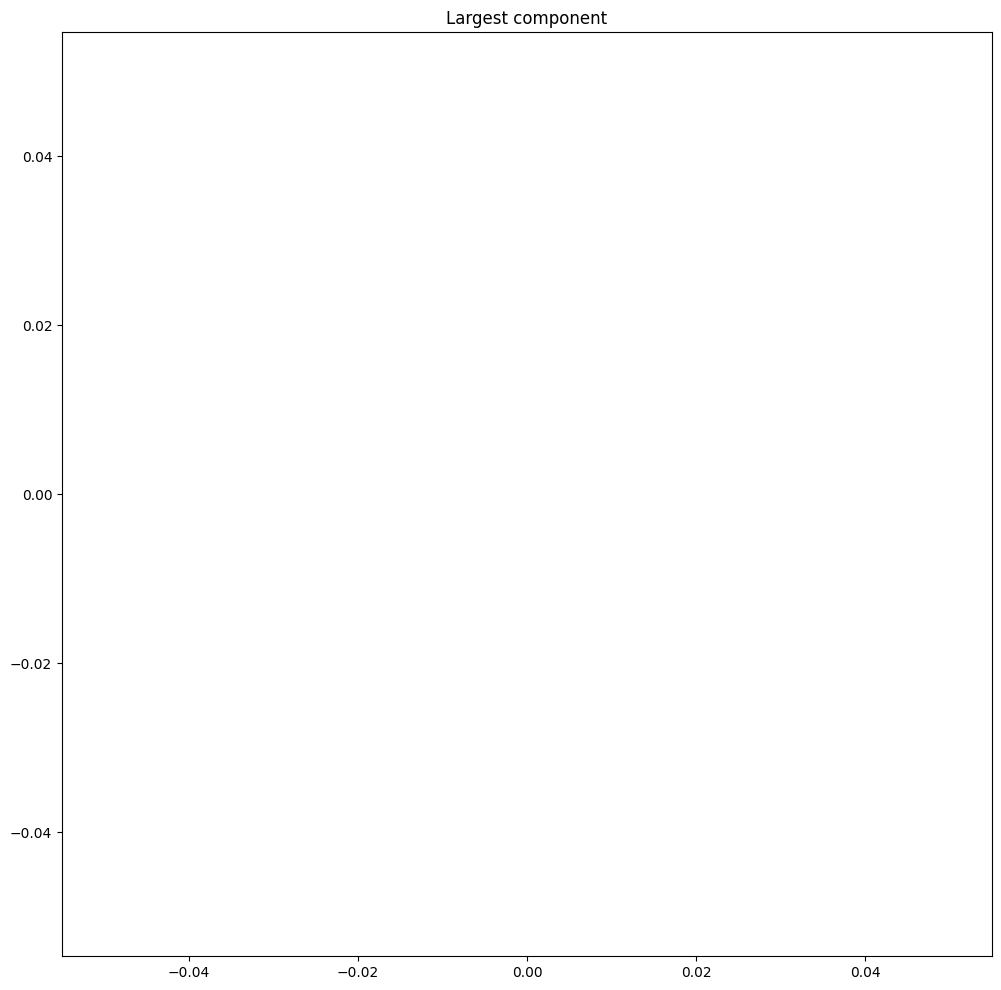

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout

largest_component = max(components, key=len)

# Create a subgraph of the largest component
H = G.subgraph(largest_component)


# circular layout
pos = nx.circular_layout(H)

plt.figure(figsize=(12, 12))
# nx.draw(
#     H,
#     pos,
#     with_labels=True,
#     node_size=50,
#     node_color="skyblue",
#     edge_color="gray",
#     font_size=8,
# )
plt.title("Largest component")
plt.axis("equal")
plt.show()

In [4]:
# Load package stats
stats = pd.read_csv(
    "data/csv/package_stats_with_contributors.csv",
    dtype={
        "install": "Int64",
        "install-on-request": "Int64",
        "contributors_count": "Int64",
    },
)
stats.loc[:, "repo_url"] = stats.loc[:, "repo_url"].fillna("")
stats.sort_values("install", ascending=False).head()

,Unnamed: 0,package,repo_url,install,install-on-request,contributors_count
3366,3390,openssl@3,,4237387,638832,<NA>
6589,6613,ca-certificates,,3328460,132784,<NA>
847,847,xz,,3074695,552466,<NA>
572,572,python@3.11,,2931813,1659811,<NA>
4654,4678,glib,,2605589,749141,<NA>


In [5]:
# Associate package stats with each node.

nodes_to_remove = []  # We can't modify the graph during iteration
for node in G.nodes:
    if node not in stats["package"].values:
        print(f"{node} not found in stats")
        nodes_to_remove.append(node)
        continue
    stats_row = stats[stats["package"] == node].iloc[0]
    G.nodes[node]["install"] = stats_row["install"]
    G.nodes[node]["install_on_request"] = stats_row["install-on-request"]
    if not pd.isnull(stats_row["contributors_count"]):
        G.nodes[node]["contributors_count"] = stats_row["contributors_count"]

print(f"Removing {len(nodes_to_remove)} nodes")
G.remove_nodes_from(nodes_to_remove)

liboauth not found in stats
pygit2 not found in stats
python not found in stats
wal2json not found in stats
gypsy not found in stats
gtksourceview3 not found in stats
wiiuse not found in stats
bit not found in stats
dtrx not found in stats
openssl not found in stats
libraqm not found in stats
thrift@0.9 not found in stats
zboy not found in stats
cryptominisat not found in stats
ibex not found in stats
resty not found in stats
cf2tf not found in stats
fgbio not found in stats
hexer not found in stats
cvs-fast-export not found in stats
libtar not found in stats
pppd not found in stats
Removing 22 nodes


In [98]:
def find_dependents_to_infect(package, popularity_metric="contributors_count"):
    """Finds all direct and indirect dependents of this package, sorting by the given popularity metric.

    We assume here that the package with the smallest metric (by default number of contributors)  lacks maintainers, and is therefore vulnerable to an XZ-style attack.
    """

    dependents = set()
    node = G.nodes[package]
    if popularity_metric in node:
        dependents.add((package, node[popularity_metric]))

    for dependent in G.predecessors(package):
        dependents.update(find_dependents_to_infect(dependent, popularity_metric))

    return sorted(dependents, key=lambda x: x[1])

In [7]:
find_dependents_to_infect("ruby")

[('zlib', 45), ('ruby', 778)]

In [8]:
find_dependents_to_infect("ruby", "install_on_request")

[('gperf', 2760),
 ('libxcrypt', 3961),
 ('libffi', 89561),
 ('ca-certificates', 132784),
 ('libyaml', 181738),
 ('zlib', 196695),
 ('ruby', 320779),
 ('openssl@3', 638832)]

## Number of dependencies histogram


Top 10 packages by dependency count


,Package,Number of Dependencies
2436,rtabmap,305
3581,dynare,282
2103,octave,279
3608,synfig,277
2348,siril,277
1946,visp,276
3609,mlt,264
3353,caffe,262
1784,mxnet,258
1785,opencv,257


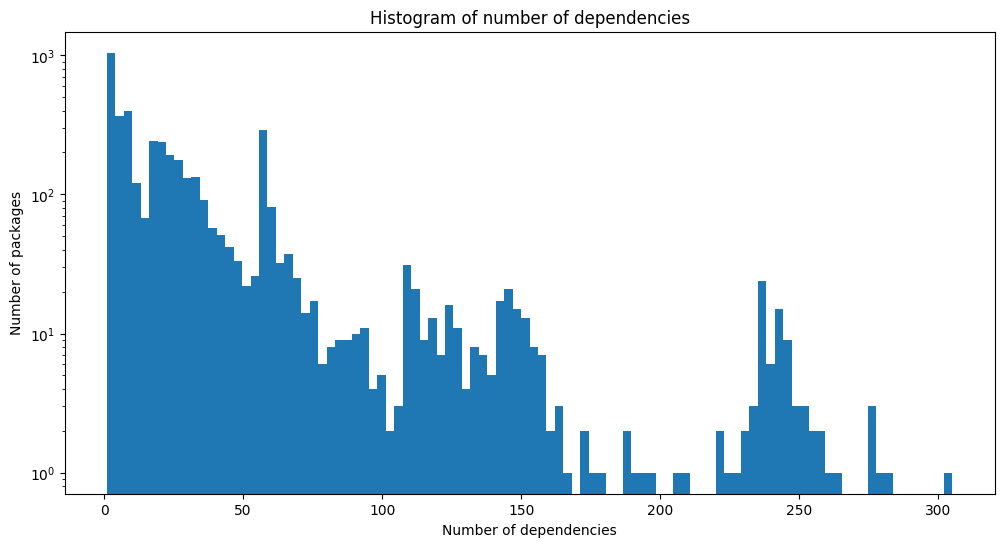

In [9]:
data_dir = Path("data")


def count_dependencies_reaching_package(graph, package_node):
    dependencies = set(nx.ancestors(graph, package_node))
    return len(dependencies)


dependency_counts = {
    node: count_dependencies_reaching_package(G, node)
    for node in G.nodes
    if G.in_degree(node) > 0
}

dependency_counts_df = pd.DataFrame(
    list(dependency_counts.items()), columns=["Package", "Number of Dependencies"]
)


print("Top 10 packages by dependency count")
dependency_counts_df = dependency_counts_df.sort_values(
    "Number of Dependencies", ascending=False
)

display(dependency_counts_df.head(10))


# histogram of dependency count
plt.figure(figsize=(12, 6))
plt.hist(dependency_counts.values(), bins=100, log=True)
plt.xlabel("Number of dependencies")
plt.ylabel("Number of packages")
plt.title("Histogram of number of dependencies")
plt.show()

# Hierarchical dependency graph for the qt package


In [10]:
# df_qt = pd.read_csv("data/csv/qt.csv")

package_stats = pd.read_csv("data/csv/package_stats_with_contributors.csv")

# display(package_stats.head(10))

# G_qt = nx.from_pandas_edgelist(
#     df_qt, target="package", source="dependency", create_using=nx.DiGraph()
# )

# pos_hierarchic = nx.nx_agraph.graphviz_layout(G_qt, prog="dot")

# nx.draw(
#     G_qt,
#     pos_hierarchic,
#     with_labels=False,
#     node_size=50,
#     node_color="skyblue",
#     edge_color="gray",
#     font_size=8,
# )
# plt.title("qt package dependency graph")

# plt.tight_layout()
# plt.show()

# Prepare Edge Weights (infection probabilities)

0         NaN
1         NaN
2    0.947149
3         NaN
4         NaN
Name: contributors_count, dtype: float64


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 2.000e+0

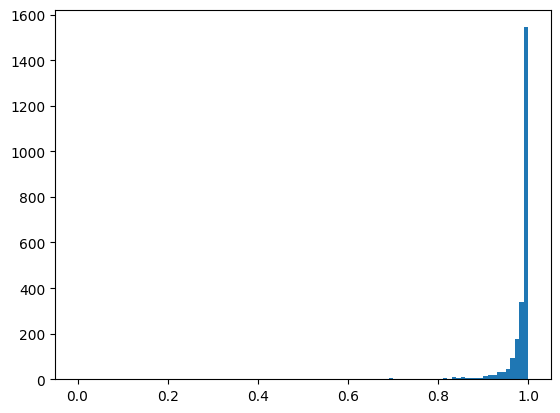

In [244]:
a, b = 0.02, 0.95
contributors = package_stats['contributors_count']
normalized_contributors = -(contributors-contributors.min())/(contributors.max()-contributors.min()) + 1
normalized_and_scaled_contributors = normalized_contributors * (b - a) + a
print(normalized_and_scaled_contributors.head())
plt.hist(normalized_contributors, bins=100)

# Infection impact analysis


In [13]:
pip install ndlib


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.8 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 13.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [229]:
from ndlib.models.epidemics import IndependentCascadesModel
from ndlib.models import ModelConfig
import math
import random
SUSC, INF, REM = 0, 1, 2

def get_infection_probability(edge, min_infection_probability):
    contributors_indices = package_stats.index[package_stats['package'] == edge[1]]
#     print(edge, contributors_indices)
    if len(contributors_indices) > 0:
        # Assumes only one item, will throw an exception if there's more (there shouldn't be)
        infection_probability = normalized_and_scaled_contributors.loc[contributors_indices.item()]
    else:
        infection_probability = min_infection_probability
    return infection_probability


def estimate_infection_fallout(first_package, min_infection_probability):
    model = IndependentCascadesModel(G)
    config = ModelConfig.Configuration()
    config.add_model_initial_configuration("Infected", [first_package])

    for edge in G.edges:
        infection_probability = get_infection_probability(edge, min_infection_probability)
        infection_probability = infection_probability if not math.isnan(infection_probability) else 0.90
        config.add_edge_configuration("threshold", edge, infection_probability)

    model.set_initial_status(config)
    iterations = model.iteration_bunch(20)

    infected_packages, infected_users = 0, 0
    for iteration in iterations:
        status = iteration["status"]
        for node, node_status in status.items():
            if node_status == INF:
                infected_packages += 1
                # We can't sum installs directly, as installing a package also installs its dependencies, so some users might be counted multiple times.
                # Instead, we rely on the fact that a package is either installed or request or as a dependency
                # In the latter case, it will be counted when we analyze its dependent packages.
                infected_users += G.nodes[node]["install_on_request"]
        trends = model.build_trends(iterations)
    return model, trends, infected_packages, infected_users

def estimate_graph_infection_fallout(first_package, min_infection_probability,graph):
    model = IndependentCascadesModel(graph)
    config = ModelConfig.Configuration()
    
#     print(model.available_statuses)
    for edge in graph.edges:
        infection_probability = get_infection_probability(edge, min_infection_probability)
        infection_probability = infection_probability if not math.isnan(infection_probability) else 0.47495
        config.add_edge_configuration("threshold", edge, infection_probability)
        
    contributors_indices = package_stats.index[package_stats['package'] == first_package]
    init_prob = normalized_and_scaled_contributors[contributors_indices.item()]
#     print(random.random(),init_prob)
    if random.random() <= init_prob:
        config.add_model_initial_configuration("Infected", [first_package])
    else:
        return 0,[],0,0,[]
    model.set_initial_status(config)
    iterations = model.iteration_bunch(20)

    infected_packages, infected_users = 0, 0
    infected = []
    for iteration in iterations:
        status = iteration["status"]
        for node, node_status in status.items():
            if node_status == INF:
                infected.append(node)
                infected_packages += 1
                # We can't sum installs directly, as installing a package also installs its dependencies, so some users might be counted multiple times.
                # Instead, we rely on the fact that a package is either installed or request or as a dependency
                # In the latter case, it will be counted when we analyze its dependent packages.
                infected_users += G.nodes[node]["install_on_request"]
        trends = model.build_trends(iterations)
    return model, trends, infected_packages, infected_users, infected

In [230]:
# from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
# model, trends, infected_packages, infected_users = estimate_infection_fallout("openssl@3", a)
# print(f"Estimated number of infected packages: {infected_packages}")
# print(f"Estimated number of infected users: {infected_users}")
# DiffusionTrend(model, trends).plot()

zimg 8 2.95 846394.0 0.4
graphite2 12 6.7 2079662.5 0.75
opencl-icd-loader 33 4.35 900746.8 0.65
snappy 35 5.6 1220658.9 0.75
jpeg-turbo 41 13.05 3082287.55 0.85
zlib 45 55.25 8804516.4 0.95
libusrsctp 55 1.95 106513.65 0.1
highway 58 1.8 436363.35 0.15
libxkbcommon 58 3.1 225005.75 0.15
double-conversion 65 3.15 261487.4 0.4
glew 67 1.55 58668.5 0.2
srtp 75 2.15 108110.4 0.0
openjpeg 79 4.6 1489343.85 0.75
cups 93 3.1 220288.75 0.25
netcdf 96 1.7 93941.6 0.25
unbound 98 2.75 1148293.7 0.15
brotli 99 5.4 1514064.05 0.35
rav1e 105 3.7 979769.2 0.35
taglib 110 2.3 129178.75 0.1
srt 117 2.7 864121.65 0.2
boost 134 1.75 326118.3 0.25
glog 134 1.75 75492.05 0.5
jsoncpp 173 1.9 176398.75 0.3
tesseract 175 3.15 1297617.75 0.3
abseil 201 1.65 176290.75 0.3
harfbuzz 212 5.9 2321571.3 0.7
spirv-tools 232 3.6 101071.25 0.0
z3 281 1.5 81573.15 0.0
glslang 282 2.5 95692.85 0.15
mbedtls 316 3.05 581912.95 0.35
zstd 320 18.15 3383486.5 0.8
openvino 512 3.95 953768.15 0.7
assimp 572 1.95 143942.2 0.15

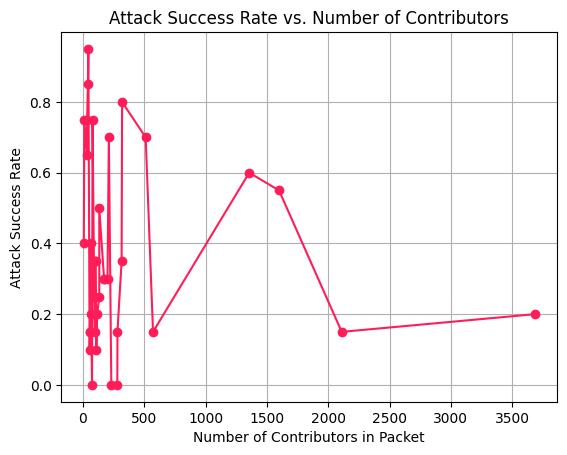

zimg 8 4.3 947881.15 0.45
graphite2 12 9.65 2485437.15 0.85
cminpack 14 2.35 4435.0 0.7
laszip 25 2.55 2605.6 0.8
uriparser 25 2.2 36536.7 0.3
qhull 27 3.0 47017.25 0.75
opencl-icd-loader 33 5.65 943780.1 0.65
snappy 35 8.2 1222598.95 0.85
jpeg-turbo 41 17.2 3091738.0 0.95
zlib 45 76.2 10720983.9 1.0
rtabmap 47 1.0 371.0 1.0
re2 55 3.2 160486.7 0.2
libusrsctp 55 2.3 100650.05 0.2
highway 58 1.7 341769.2 0.1
libxkbcommon 58 6.0 223708.75 0.95
double-conversion 65 4.25 215051.7 0.7
glew 67 3.55 74413.6 0.9
srtp 75 1.9 83709.4 0.1
openjpeg 79 7.35 1572683.15 0.8
cups 93 3.8 205700.7 0.45
netcdf 96 2.95 118210.05 0.55
unbound 98 4.7 1646796.3 0.25
brotli 99 9.75 1307529.05 0.9
rav1e 105 3.9 815242.6 0.4
taglib 110 1.8 66507.15 0.1
srt 117 4.75 1113493.45 0.7
aws-sdk-cpp 122 2.15 78481.5 0.2
json-c 129 1.95 51621.55 0.3
boost 134 3.2 309727.7 0.85
glog 134 3.55 146524.55 0.6
libpcap 140 2.75 13324.45 0.85
c-ares 141 2.45 149578.25 0.1
proj 160 3.3 111235.9 0.45
pdal 164 1.5 2516.6 0.65
json

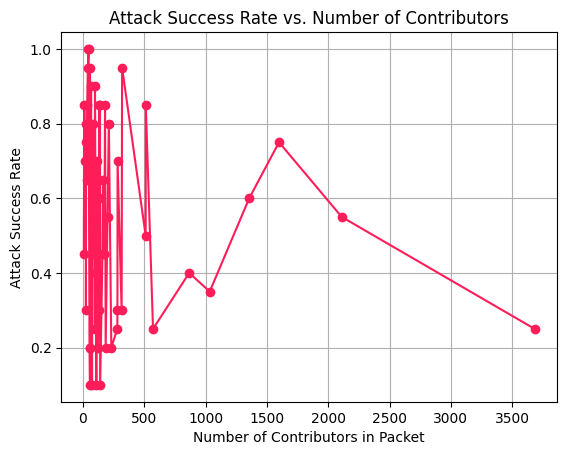

zimg 8 4.7 1163561.2 0.95
graphite2 12 7.5 2217556.0 0.8
opencl-icd-loader 33 4.45 769256.45 0.7
snappy 35 5.75 1140360.05 0.85
jpeg-turbo 41 14.8 3316217.75 1.0
zlib 45 55.4 8385119.95 0.95
libusrsctp 55 2.0 91382.7 0.2
highway 58 4.55 1290197.2 0.55
libxkbcommon 58 4.25 274217.45 0.65
double-conversion 65 2.9 178566.65 0.45
glew 67 1.65 56115.7 0.2
srtp 75 2.15 106443.1 0.2
openjpeg 79 5.65 1490036.25 0.8
cups 93 3.0 184343.55 0.45
mlt 94 0.85 3668.6 0.85
netcdf 96 2.0 101478.25 0.25
unbound 98 3.6 1326224.45 0.3
brotli 99 6.1 1466945.2 0.65
rav1e 105 3.6 761271.5 0.65
taglib 110 2.2 104577.25 0.2
srt 117 4.25 1107098.6 0.75
boost 134 1.95 323438.95 0.2
glog 134 2.7 97010.35 0.55
jsoncpp 173 2.9 245088.0 0.4
tesseract 175 4.1 1330309.3 0.65
abseil 201 1.2 106521.8 0.1
harfbuzz 212 7.3 2346795.25 0.85
spirv-tools 232 4.55 134673.05 0.3
z3 281 2.25 119235.5 0.1
glslang 282 3.55 130929.55 0.2
mbedtls 316 4.2 758769.65 0.6
zstd 320 14.95 3002569.85 0.85
openvino 512 4.3 837648.15 0.8
ass

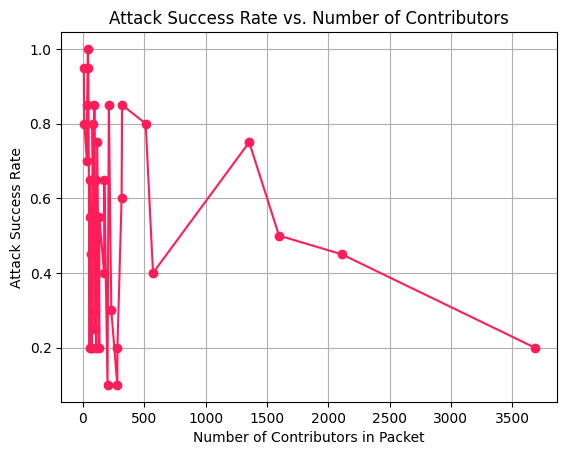

liblqr 2 2.6 718391.35 0.4
zimg 8 2.8 751594.05 0.25
graphite2 12 6.4 1893031.2 0.4
qhull 27 1.35 15401.2 0.4
opencl-icd-loader 33 3.1 496129.45 0.25
snappy 35 4.35 1085427.25 0.3
jpeg-turbo 41 18.85 4227729.9 0.9
zlib 45 62.5 9507753.5 1.0
portaudio 48 1.5 51768.5 0.5
arpack 51 1.5 27912.15 0.55
libusrsctp 55 2.2 116883.15 0.2
highway 58 4.1 1225541.6 0.25
libxkbcommon 58 4.2 271432.9 0.4
double-conversion 65 2.7 163351.05 0.45
srtp 75 2.0 94023.1 0.1
openjpeg 79 8.2 2477572.95 0.9
cups 93 2.2 98958.5 0.15
unbound 98 3.2 1125633.2 0.2
brotli 99 6.9 1848646.0 0.75
rav1e 105 2.9 825767.4 0.2
taglib 110 2.25 104222.2 0.25
srt 117 3.2 950153.4 0.2
libpcap 140 1.3 14310.6 0.05
imagemagick 159 1.85 836032.65 0.25
tesseract 175 3.1 1324112.5 0.2
rapidjson 186 1.55 21764.15 0.55
harfbuzz 212 6.6 2370341.95 0.7
spirv-tools 232 4.35 101621.4 0.3
z3 281 2.4 148243.5 0.15
glslang 282 3.45 101825.1 0.3
mbedtls 316 2.2 373190.85 0.05
zstd 320 22.7 3809011.55 0.95
openvino 512 2.7 676030.6 0.2
perl 

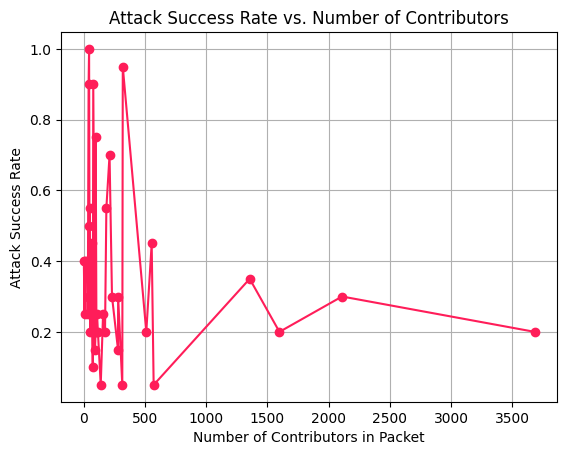

In [245]:
graphs = ['opencv','rtabmap','mlt','octave']
for package in graphs:
    package_csv = pd.read_csv("data/csv/"+package+".csv")
    graph = nx.from_pandas_edgelist(
    package_csv, target="package", source="dependency", create_using=nx.DiGraph())
    candidates = find_dependents_to_infect(package)
    iterations = 20
    success_attack = 0
    infested_packages_sum = 0
    infested_users_sum = 0
    plot_metrics = []
    plot_sr = []
    for source, metric in candidates:
        success_attack = 0
        infested_packages_sum = 0
        infested_users_sum = 0
        for iterate in range(iterations):
            model, trends, infected_packages, infected_users,infected_list = estimate_graph_infection_fallout(source, a, graph)
    #         print(f"Estimated number of infected packages: {infected_packages}")
    #         print(f"Estimated number of infected users: {infected_users}")
            if package in infected_list:
                success_attack +=1
            infested_packages_sum += infected_packages
            infested_users_sum += infected_users
        success_attack /= iterations
        infested_packages_sum /= iterations
        infested_users_sum /= iterations
        plot_metrics.append(metric)
        plot_sr.append(success_attack)
        print(source, metric, infested_packages_sum,infested_users_sum, success_attack)
#         print(infected_list)
    plt.xlabel('Number of Contributors in Packet')
    plt.ylabel('Attack Success Rate')
    plt.title('Attack Success Rate vs. Number of Contributors')
    plt.plot(plot_metrics,plot_sr,"#ff1d59", marker='o')
    plt.grid(True)
    plt.show()